In [40]:
import os
import cv2
import numpy as np
from scipy import ndimage
from scipy.signal import convolve2d
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.imgutils import *
from utils.functions import *
from utils.pairs import *

In [41]:
filename = '../project_github/IrisRecognition/CASIA1/1/001_1_1.jpg'
img = cv2.imread(filename, 0)
print(img.shape)

# Params
eyelashes_threshold = 80
radial_resolution = 20
angular_resolution = 240    
minw_length = 18
mult = 1
sigma_f = 0.5

# Three step pipeline - Segmentation, normalization, feature encoding
# Segmentation
ciriris, cirpupil, imwithnoise = segment(img, 80, False)

# Normalization
arr_polar, arr_noise = normalize(imwithnoise, ciriris[1],  ciriris[0], ciriris[2],
                                    cirpupil[1], cirpupil[0], cirpupil[2],
                                    radial_resolution, angular_resolution)

# Feature encoding
template, mask_noise = encode_iris(arr_polar, arr_noise, minw_length, mult, sigma_f)

(280, 320)


In [42]:
def encode_features(filename, eyelashes_threshold = 80):
    # Parameters
    eyelashes_threshold = 80
    radial_resolution = 20
    angular_resolution = 240
    minw_length = 18
    mult = 1
    sigma_f = 0.5
    multiprocess = False
    #  segmentation
    im = imread(filename, 0)
    ciriris, cirpupil, imwithnoise = segment(im, eyelashes_threshold,
                                    multiprocess)

    # normalization
    arr_polar, arr_noise = normalize(imwithnoise, ciriris[1],  ciriris[0], ciriris[2],
                                         cirpupil[1], cirpupil[0], cirpupil[2],
                                         radial_resolution, angular_resolution)

    #  feature encoding
    template, mask_noise = encode_iris(arr_polar, arr_noise, minw_length, mult,
    sigma_f)
    

    return template, mask_noise, filename



In [43]:
def extract_and_store(filenames_list, output_dir = 'features'):
    os.makedirs(output_dir, exist_ok = True)
    print(f"\nExtracting and storing features in '{output_dir}'...")

    for img_filename in tqdm(filenames_list, desc="Processing images"):
        template, mask, original_path = encode_features(img_filename)

        if template is not None and mask is not None:
            # Create a unique filename for the template and mask
            # For example, 'IITD/001/01_L.bmp' becomes 'features/001_01_L.npy'
            relative_path = os.path.relpath(original_path, start='IITD')
            base_name = os.path.splitext(relative_path)[0].replace(os.sep, '_')
            
            template_filename = os.path.join(output_dir, f'{base_name}_template.npy')
            mask_filename = os.path.join(output_dir, f'{base_name}_mask.npy')

            # Save the numpy arrays to disk
            np.save(template_filename, template)
            np.save(mask_filename, mask)


In [44]:
# Run for all the files in the dataset -
def pipeline(extract = False):
    dataset_path = '../datasets/IITD'

    all_filenames = get_filenames(dataset_path)
    print(f"Found {len(all_filenames)} .bmp files")

    structured_data = get_users(all_filenames)
    if structured_data:
        print(f"Successfully organized data for {len(structured_data)} users.")
    else:
        print("Could not find any user data. Please check the 'dataset_path'.")

    
    print(all_filenames[0])
    if (extract):
        extract_and_store(all_filenames)
    print("\nFeature extraction and storage complete.")

    return all_filenames, structured_data
    

In [45]:
all_filenames, structured_data = pipeline()

Found 2240 .bmp files
Organizaing users for 2240 files
Successfully organized data for 224 users.
../datasets/IITD/196/09_R.bmp

Feature extraction and storage complete.


In [46]:
def load_template_and_mask(image_path, features_dir='features'):
    """
    Loads a template and mask based on the original image path,
    now correctly handling your specific file naming convention.
    """
    try:
        # Step 1: Get the full path to the image, relative to the current working directory
        full_image_path_norm = os.path.normpath(image_path)
        
        # Step 2: Get the filename part and the path part without the extension
        path_without_ext, _ = os.path.splitext(full_image_path_norm)
        
        # Step 3: Recreate the base name string by replacing path separators
        # This matches the pattern '.._.._datasets_IITD_...'
        base_name = path_without_ext.replace(os.sep, '_').replace('..', '.._..')
        
        # Step 4: Construct the full path to the feature files
        template_filename = os.path.join(features_dir, f'{base_name}_template.npy')
        mask_filename = os.path.join(features_dir, f'{base_name}_mask.npy')
        
        # Print the path for debugging to ensure it's correct
        #print(f"Loading files from: {template_filename}")
        
        template = np.load(template_filename)
        mask = np.load(mask_filename)
        return template, mask
    except FileNotFoundError:
        print(f"Error: Template or mask not found for {image_path}.")
        print(f"Looked for: '{template_filename}'")
        return None, None
    except Exception as e:
        print(f"An error occurred loading features for {image_path}: {e}")
        return None, None

def compare_pairs(pairs_list, features_dir='features', is_genuine=True):
    """
    Calculates and returns the list of Hamming distances for a given list of pairs.
    """
    distances = []
    pair_type = "Genuine" if is_genuine else "Impostor"
    
    print(f"\nCalculating Hamming distances for {len(pairs_list)} {pair_type.lower()} pairs...")
    
    for pair in tqdm(pairs_list, desc=f"Comparing {pair_type} pairs"):
        img_path1, img_path2 = pair
        
        template1, mask1 = load_template_and_mask(img_path1, features_dir)
        template2, mask2 = load_template_and_mask(img_path2, features_dir)

        if template1 is not None and template2 is not None:
            distance = HammingDistance(template1, mask1, template2, mask2)
            if not np.isnan(distance):
                distances.append(distance)
    
    return distances

def plot_distributions(genuine_distances, impostor_distances):
    """
    Creates and displays a histogram of the genuine and impostor Hamming distances.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(genuine_distances, bins=50, alpha=0.5, label='Genuine Pairs')
    plt.hist(impostor_distances, bins=50, alpha=0.5, label='Impostor Pairs')
    
    plt.title('Distribution of Hamming Distances')
    plt.xlabel('Hamming Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

In [49]:
def test( all_filenames, structured_data, features_path = './features'):
    # Generate genuine pairs
    genuine_pairs = generate_genuine_pairs(structured_data)
    print(f"\n--- Pair Generation Summary ---")
    print(f"Found {len(genuine_pairs)} genuine pairs.")

    num_impostor_pairs_to_generate = len(genuine_pairs)
    impostor_pairs = generate_impostor_pairs(structured_data, num_impostor_pairs_to_generate)
    print(f"Generated {len(impostor_pairs)} impostor pairs.")
    

    print("\n--- Example Pairs ---")
    if genuine_pairs:
        print("Genuine Pair Example:")
        print(f"  {genuine_pairs[0]}")
    if impostor_pairs:
        print("Impostor Pair Example:")
        print(f"  {impostor_pairs[0]}")
    genuine_distances = compare_pairs(genuine_pairs, features_path, is_genuine=True)
    impostor_distances = compare_pairs(impostor_pairs, features_path, is_genuine=False)

     # Step 3: Plot the distributions
    if genuine_distances and impostor_distances:
        plot_distributions(genuine_distances, impostor_distances)
    else:
        print("\nCould not generate the plot. Please check if the 'features' directory exists and contains data.")
    return genuine_distances, impostor_distances, impostor_pairs


Generated - 4808 genuine pairs

--- Pair Generation Summary ---
Found 4808 genuine pairs.
Generating 4808 impostor pairs...
Generated 4808 impostor pairs.

--- Example Pairs ---
Genuine Pair Example:
  ('../datasets/IITD/196/09_R.bmp', '../datasets/IITD/196/10_R.bmp')
Impostor Pair Example:
  ('../datasets/IITD/024/07_R.bmp', '../datasets/IITD/181/02_L.bmp')

Calculating Hamming distances for 4808 genuine pairs...


Comparing Genuine pairs: 100%|██████████| 4808/4808 [00:05<00:00, 824.70it/s]



Calculating Hamming distances for 4808 impostor pairs...


Comparing Impostor pairs: 100%|██████████| 4808/4808 [00:05<00:00, 826.38it/s]


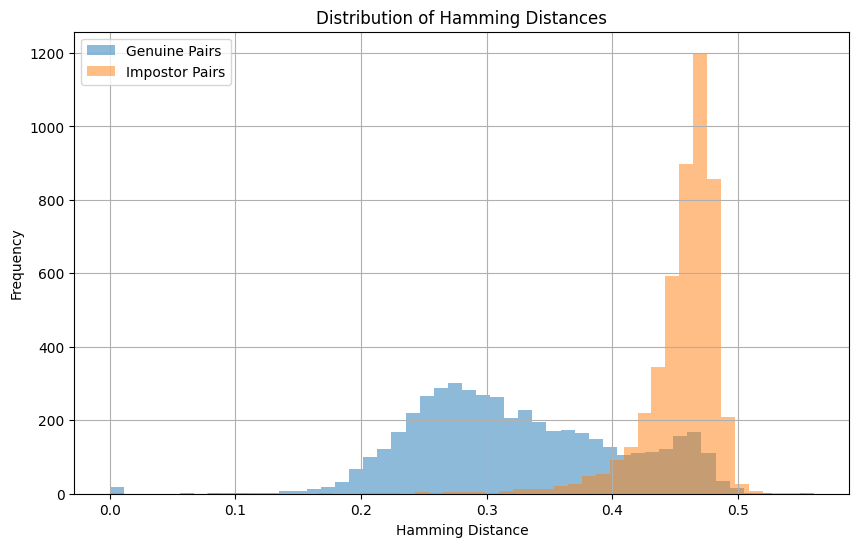

In [50]:
genuine_distances, impostor_distances, impostor_pairs = test(all_filenames, structured_data)


In [56]:
import numpy as np

def analyze_full_overlap(genuine_distances, impostor_distances, impostor_pairs):
    """
    Analyzes the overlap between genuine and impostor distributions,
    including finding the specific pair with the smallest impostor distance.
    
    Args:
        genuine_distances (list): List of Hamming distances for genuine pairs.
        impostor_distances (list): List of Hamming distances for impostor pairs.
        impostor_pairs (list): List of tuples representing the impostor pairs.
    """
    if not impostor_distances or not impostor_pairs:
        print("Impostor data is missing. Cannot perform analysis.")
        return
        
    # Find the minimum impostor distance
    min_impostor_distance = min(impostor_distances)
    
    # Find the index of the first occurrence of the minimum distance
    min_impostor_index = impostor_distances.index(min_impostor_distance)
    
    # Use the index to find the corresponding impostor pair
    min_impostor_pair = impostor_pairs[min_impostor_index]

    print("\n--- Full Overlap Analysis ---")
    print(f"Smallest impostor distance: {min_impostor_distance:.4f}")
    print(f"This distance belongs to the pair: {min_impostor_pair}")

    # Count genuine distances greater than the minimum impostor distance
    count_genuine_greater = 0
    for hd in genuine_distances:
        if hd > min_impostor_distance:
            count_genuine_greater += 1
            
    # Print the results
    total_genuine = len(genuine_distances)
    if total_genuine > 0:
        percentage_greater = (count_genuine_greater / total_genuine) * 100
        print(f"Number of genuine distances greater than this value: {count_genuine_greater}")
        print(f"Percentage of genuine pairs with distances greater than this value: {percentage_greater:.2f}%")
    else:
        print("No genuine distances to compare.")

analyze_full_overlap(genuine_distances, impostor_distances, impostor_pairs)


--- Full Overlap Analysis ---
Smallest impostor distance: 0.0000
This distance belongs to the pair: ('../datasets/IITD/123/07_R.bmp', '../datasets/IITD/141/02_L.bmp')
Number of genuine distances greater than this value: 4790
Percentage of genuine pairs with distances greater than this value: 99.65%


In [59]:
import numpy as np

def calculate_average_distances(genuine_distances, impostor_distances):
    """
    Calculates and prints the average Hamming distances for both
    genuine and impostor pairs.

    Args:
        genuine_distances (list): List of Hamming distances for genuine pairs.
        impostor_distances (list): List of Hamming distances for impostor pairs.
    """
    if genuine_distances:
        avg_genuine_hd = np.mean(genuine_distances)
        print(f"Average Genuine Hamming Distance: {avg_genuine_hd:.4f}")
    else:
        print("No genuine distances to calculate the average.")
        
    if impostor_distances:
        avg_impostor_hd = np.mean(impostor_distances)
        print(f"Average Impostor Hamming Distance: {avg_impostor_hd:.4f}")
    else:
        print("No impostor distances to calculate the average.")

calculate_average_distances(genuine_distances, impostor_distances)

Average Genuine Hamming Distance: 0.3238
Average Impostor Hamming Distance: 0.4552


In [58]:
def load_template_and_mask(image_path, features_dir='features'):
    try:
        full_image_path_norm = os.path.normpath(image_path)
        path_without_ext, _ = os.path.splitext(full_image_path_norm)
        base_name = path_without_ext.replace(os.sep, '_').replace('..', '.._..')
        
        template_filename = os.path.join(features_dir, f'{base_name}_template.npy')
        mask_filename = os.path.join(features_dir, f'{base_name}_mask.npy')
        
        template = np.load(template_filename)
        mask = np.load(mask_filename)
        return template, mask
    except FileNotFoundError:
        print(f"Error: Template or mask not found for {image_path}.")
        print(f"Looked for: '{template_filename}'")
        return None, None
    except Exception as e:
        print(f"An error occurred loading features for {image_path}: {e}")
        return None, None


# The impostor pair you are investigating
impostor_pair = ('../datasets/IITD/123/07_R.bmp', '../datasets/IITD/141/02_L.bmp')

# The directory where your features are stored
features_path = './features'

# --- Load the templates and masks for the pair ---
path1, path2 = impostor_pair

print("--- Loading features for Pair 1 ---")
template1, mask1 = load_template_and_mask(path1, features_path)

print("\n--- Loading features for Pair 2 ---")
template2, mask2 = load_template_and_mask(path2, features_path)


# --- Inspect the loaded data ---
if template1 is not None and template2 is not None:
    print("\n--- Inspection of Loaded Data ---")

    print(f"Template 1 shape: {template1.shape}")
    print(f"Template 1 (first 5x5): \n{template1[:5, :5]}")
    print(f"Template 1 (unique values): {np.unique(template1)}")
    
    print(f"\nMask 1 shape: {mask1.shape}")
    print(f"Mask 1 (first 5x5): \n{mask1[:5, :5]}")
    print(f"Mask 1 (unique values): {np.unique(mask1)}")

    print(f"\nTemplate 2 shape: {template2.shape}")
    print(f"Template 2 (first 5x5): \n{template2[:5, :5]}")
    print(f"Template 2 (unique values): {np.unique(template2)}")
    
    print(f"\nMask 2 shape: {mask2.shape}")
    print(f"Mask 2 (first 5x5): \n{mask2[:5, :5]}")
    print(f"Mask 2 (unique values): {np.unique(mask2)}")

    # --- Manual Hamming Distance Calculation for Verification ---
    print("\n--- Manual Hamming Distance Verification (without shifts) ---")

    # Combine the masks
    combined_mask = np.logical_or(mask1, mask2)
    
    # Calculate XOR of templates
    xor_result = np.logical_xor(template1, template2)
    
    # Apply combined mask to XOR result
    diff_bits = np.logical_and(xor_result, np.logical_not(combined_mask))
    
    # Count differing bits and total bits to compare
    bits_diff = np.sum(diff_bits)
    total_bits = template1.size - np.sum(combined_mask)
    
    # Calculate HD
    if total_bits > 0:
        hd = bits_diff / total_bits
    else:
        hd = np.nan

    print(f"Total bits to compare (not masked): {total_bits}")
    print(f"Number of bits that differ: {bits_diff}")
    print(f"Hamming Distance (no shifts): {hd:.4f}")
    
    if hd == 0.0:
        print("\n**Warning: Hamming Distance is 0.0. Possible issues:**")
        if total_bits == 0:
            print("  - Both masks are completely covering the templates, leaving no bits to compare.")
        elif np.array_equal(template1, template2):
            print("  - The templates are identical, which should not happen for an impostor pair.")
        else:
            print("  - The templates differ only in masked regions.")

--- Loading features for Pair 1 ---

--- Loading features for Pair 2 ---

--- Inspection of Loaded Data ---
Template 1 shape: (20, 480)
Template 1 (first 5x5): 
[[1. 0. 1. 1. 1.]
 [1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1.]]
Template 1 (unique values): [0. 1.]

Mask 1 shape: (20, 480)
Mask 1 (first 5x5): 
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Mask 1 (unique values): [0. 1.]

Template 2 shape: (20, 480)
Template 2 (first 5x5): 
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0.]]
Template 2 (unique values): [0. 1.]

Mask 2 shape: (20, 480)
Mask 2 (first 5x5): 
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Mask 2 (unique values): [0. 1.]

--- Manual Hamming Distance Verification (without shifts) ---
Total bits to compare (not masked): 44
Number of bits that differ: 5
Hamming Distance (no shifts): 0.1136
